In [ ]:
import os
!pip install pyspark
!pip install -U -q PyDrive
!apt-get install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, current_timestamp, to_date, hour, dayofweek

import numpy as np

from itertools import combinations

In [4]:
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .master("local[*]").getOrCreate()


spark_session = create_new_spark_context("LSH")
sc = spark_session.sparkContext


In [5]:
schema = StructType([
    StructField("DEVICE_CODE", IntegerType(), True),
    StructField("SYSTEM_ID", IntegerType(), True),
    StructField("ORIGINE_CAR_KEY", StringType(), True),
    StructField("FINAL_CAR_KEY", StringType(), True),
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("COMPANY_ID", StringType(), True),
    StructField("PASS_DAY_TIME", TimestampType(), True)
])

In [ ]:
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)


First we remove the outliers from the data. Namely the cars that have been recorded more than 1000 times. We can do this by using the following code:

In [6]:
# add count column to count the number of records, group by FINAL_CAR_KEY
# define a window to count the number of records for each car

from pyspark.sql.window import Window
from pyspark.sql.functions import count

window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)


In [ ]:
rdd = df.rdd.map(lambda x: (x["FINAL_CAR_KEY"], x["DEVICE_CODE"], x["PASS_DAY_TIME"], x["SYSTEM_ID"]))
rdd.take(1)

[('10000007', 22010053, datetime.datetime(2022, 1, 12, 6, 30, 27), 284)]

## Adjacent Cameras

Here we are going to find the adjacent cameras, based on the difference of the time they have recorded the same cars. First we filter the devices having $SYSTEM\_ID \in \{81, 281, 283\}$ which are tha devices only recording passes of the cars.

In [7]:
# filter the devices with SYSTEM_ID = 81, 281, 283
pass_devices = {81, 281, 283}
rdd = rdd.filter(lambda x: x[3] in pass_devices)

Now we group the data by car and date

In [ ]:
# create rdd with ((FINAL_CAR_KEY, PASS_DAY_TIME.date()), (DEVICE_CODE, PASS_DAY_TIME.time()))

rdd = rdd.map(lambda x: ((x[0], x[2].date()), (x[1], x[2].hour * 60 + x[2].minute)))


Then we group the data by FINAL_CAR_KEY and for each car sort the list of (DEVICE_ID, PASS_DAY_TIME) by PASS_DAY_TIME. Then we calculate the difference between the consecutive PASS_DAY_TIME and we filter the ones that are less than 15 minutes. Finally we group the data by DEVICE_ID and count the number of cars that have been recorded by the same device.

In [ ]:
# Calculate adjency pair of devices
# device A and B are pair, if: 1) there is at least one car that first passed A, and then passed B, and time passed is at most 30 min

# rdd: ((FINAL_CAR_KEY, PASS_DAY_TIME.date()), (DEVICE_CODE, PASS_DAY_TIME.time()))

# group by car and date to get the list of devices and times

car_devices_times_rdd = rdd.groupByKey().mapValues(list)

# now sort the list of devices and times by time
car_devices_times_rdd = car_devices_times_rdd.mapValues(lambda x: sorted(x, key=lambda y: y[1]))

In [8]:
# Then we calculate the difference between the consecutive (device, time) pairs.
def calculate_diff(l):
    return [(l[i][0], l[i+1][1] - l[i][1]) for i in range(len(l)-1)]

# compute the difference between time of consecutive pairs
car_devices_times_diff_rdd = car_devices_times_rdd.mapValues(calculate_diff)

# Now we filter the ones that are less than 15 minutes.
car_devices_times_diff_rdd = car_devices_times_diff_rdd.mapValues(lambda x: [y for y in x if y[1] <= 15])

In [9]:
# Create pairs of devices from adjacent devices in the list of each (car, date)

def create_pairs(l):
    return list(zip(l[:-1], l[1:]))

car_devices_pairs_rdd = car_devices_times_diff_rdd.mapValues(create_pairs)

In [ ]:
rdd.count()

24512611

In [ ]:
car_devices_pairs_rdd.take(10)

[(('100020795', datetime.date(2022, 1, 8)), []),
 (('10007297', datetime.date(2022, 1, 13)), []),
 (('10027219', datetime.date(2022, 1, 11)), [((232, 4), (145, 0))]),
 (('100436790', datetime.date(2022, 1, 8)),
  [((900155, 9), (900213, 1)),
   ((900213, 1), (900212, 15)),
   ((900212, 15), (900182, 8)),
   ((900182, 8), (100701068, 15))]),
 (('100452039', datetime.date(2022, 1, 12)), []),
 (('100494468', datetime.date(2022, 1, 10)),
  [((900142, 3), (631357, 15)), ((631357, 15), (114, 4))]),
 (('100725036', datetime.date(2022, 1, 13)), []),
 (('100811826', datetime.date(2022, 1, 14)), []),
 (('100894631', datetime.date(2022, 1, 8)), []),
 (('10091804', datetime.date(2022, 1, 14)), [])]

In [ ]:
# now find the adjacent device pairs
adjacent_device_pairs = car_devices_pairs_rdd.flatMap(lambda x: x[1]).map(lambda x: (x[0][0], x[1][0]))

# filter pairs with the same device
adjacent_device_pairs = adjacent_device_pairs.filter(lambda x: x[0] != x[1])

We have candidates for adjacent cameras. Now we need to find the ones that are actually adjacent. By an approximation we can say that two cameras are adjacent if they have occurred in the calculation above more than a certain number of times. We can do this by using the following code:

In [ ]:
# group by device and count the number of pairs
adjacent_device_pairs = adjacent_device_pairs.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y)

# filter the pairs with less than 100 records
adjacent_device_pairs = adjacent_device_pairs.filter(lambda x: x[1] >= 1000)

In [ ]:
adjacent_device_pairs.count()

688

In [ ]:
adjacent_device_pairs.take(10)

[((900221, 212501), 11970),
 ((900126, 900215), 1011),
 ((900247, 145), 1098),
 ((900164, 631369), 1389),
 ((900164, 631368), 24050),
 ((900236, 631357), 1364),
 ((900155, 631363), 1635),
 ((211301, 900191), 1248),
 ((213402, 230106), 2455),
 ((900212, 900269), 1906)]

In [ ]:
# calculate the histogram of number of cars recorded by both devices in different days for all
# hours of the day

device1, device2 = 900258, 900243

# join the rdd with itself to get all pairs of records with device1 and device2
# x["FINAL_CAR_KEY"], x["DEVICE_CODE"], x["PASS_DAY_TIME"], x["SYSTEM_ID"]
# rdd = rdd.map(lambda x: ((x[0], x[2].date()), (x[1], x[2].hour * 60 + x[2].minute)))
# ((FINAL_CAR_KEY, PASS_DAY_TIME.date()), (DEVICE_CODE, PASS_DAY_TIME.time())
joined_rdd = rdd.filter(lambda x: x[1][0] == device1).join(rdd.filter(lambda x: x[1][0] == device2))

In [ ]:
joined_rdd.take(1)

[(('102898379', datetime.date(2022, 1, 10)), ((900258, 896), (900243, 424)))]

In [ ]:
# filter the pairs in interval of 15 minutes
joined_rdd = joined_rdd.filter(lambda x: abs(x[1][0][1] - x[1][1][1]) <= 15)

# group by date and hour
joined_rdd = joined_rdd.map(lambda x: ((x[0][1], x[1][0][1] // 60), 1)).reduceByKey(lambda x, y: x + y)

In [ ]:
# now collect the result
pair_records = joined_rdd.collect()

In [ ]:
# sort the result by date and hour
pair_records = sorted(pair_records, key=lambda x: (x[0][0], x[0][1]))

In [11]:
# convert weekdays from greogrian to persian
import datetime
import jdatetime

def convert_to_persian_date(date):
    # get the weekday and date in persian
    persian_date = jdatetime.date.fromgregorian(date=date)
    persian_weekday = persian_date.weekday()
    persian_date = persian_date.strftime('%Y/%m/%d')
    return persian_date, persian_weekday

# convert the date to persian
pair_records = [(convert_to_persian_date(x[0][0]), x[0][1], x[1]) for x in pair_records]

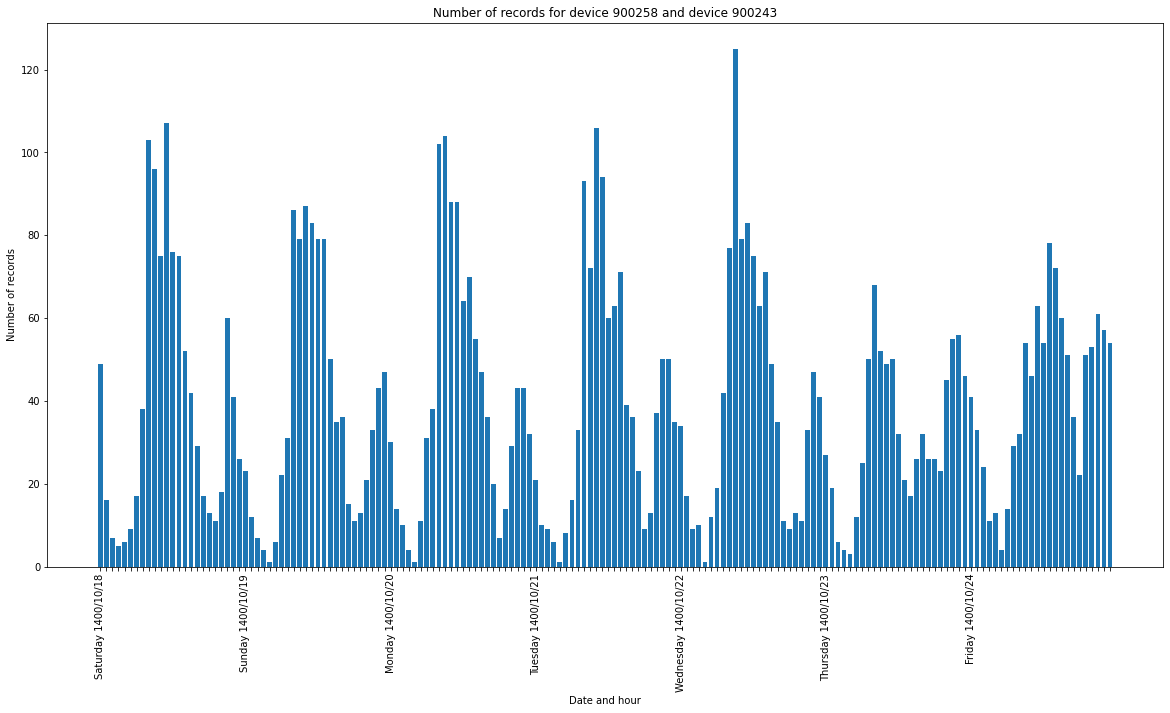

In [ ]:
# plot the histogram

import numpy as np
import matplotlib.pyplot as plt


weekdays = ["Saturday", "Sunday", "Monday",
            "Tuesday", "Wednesday", "Thursday", "Friday"]


# plot the histogram of number of records for each hour of the day
# make function from the above cell
def plot_histogram(device1, device2, pair_records):
    plt.figure(figsize=(20, 10))
    plt.bar(np.arange(len(pair_records)), [x[2] for x in pair_records])

    # set the ticks, labels and title
    # ticks should be the weekday in persian for each 24 hours
    ticks = []
    for i in range(len(pair_records)):
        if i % 24 == 0:
            ticks.append("{} {}".format(
                weekdays[pair_records[i][0][1]], pair_records[i][0][0]))
        else:
            ticks.append("")

    plt.xticks(np.arange(len(pair_records)), ticks, rotation=90)

    plt.title("Number of records for device {} and device {}".format(
        device1, device2))
    plt.xlabel("Date and hour")
    plt.ylabel("Number of records")
    plt.show()


plot_histogram(device1, device2, pair_records)

In [13]:
# load the main data
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/MDA2022ProjectData.csv', header=True, schema=schema)
window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|COUNT|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010061|      284|      100000100|    100000100|               6|       161|2021-12-29 21:11:12|    7|
|   22010087|      284|      100000100|    100000100|               6|       161|2021-12-30 17:22:15|    7|
|   22010100|      284|      100000100|    100000100|               6|       161|2021-12-30 17:55:52|    7|
|     103002|       81|      100000100|    100000100|               5|       161|2021-12-31 11:17:24|    7|
|     103001|       81|      100000100|    100000100|               5|       161|2021-12-31 11:31:13|    7|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
only showing top 5 rows



In [14]:
# get the unique dates of the data

# firs get the date from the timestamp
df = df.withColumn("date", df["PASS_DAY_TIME"].cast("date"))

# # get the unique dates
unique_dates = df.select("date").distinct().collect()
unique_dates

[Row(date=datetime.date(2022, 1, 9)),
 Row(date=datetime.date(2022, 1, 15)),
 Row(date=datetime.date(2022, 1, 18)),
 Row(date=datetime.date(2021, 12, 27)),
 Row(date=datetime.date(2022, 1, 10)),
 Row(date=datetime.date(2022, 1, 8)),
 Row(date=datetime.date(2022, 1, 16)),
 Row(date=datetime.date(2022, 1, 13)),
 Row(date=datetime.date(2021, 12, 22)),
 Row(date=datetime.date(2021, 12, 28)),
 Row(date=datetime.date(2021, 12, 26)),
 Row(date=datetime.date(2022, 1, 6)),
 Row(date=datetime.date(2021, 12, 29)),
 Row(date=datetime.date(2021, 12, 30)),
 Row(date=datetime.date(2022, 1, 3)),
 Row(date=datetime.date(2021, 12, 25)),
 Row(date=datetime.date(2022, 1, 7)),
 Row(date=datetime.date(2022, 1, 4)),
 Row(date=datetime.date(2022, 1, 17)),
 Row(date=datetime.date(2022, 1, 20)),
 Row(date=datetime.date(2021, 12, 24)),
 Row(date=datetime.date(2021, 12, 23)),
 Row(date=datetime.date(2022, 1, 5)),
 Row(date=datetime.date(2022, 1, 14)),
 Row(date=datetime.date(2022, 1, 19)),
 Row(date=datetime.date

In [ ]:
len(unique_dates)

30

This data is records from a whole month. we separate the data in batches of weeks and we calculate the number of adjacent cameras for each week. We can do this by using the following code:

In [15]:
# first get week of each date using spark functions
from pyspark.sql.functions import weekofyear

df = df.withColumn("week", weekofyear("date"))

# get the unique weeks
unique_weeks = df.select("week").distinct().collect()
unique_weeks

[Row(week=1), Row(week=52), Row(week=3), Row(week=51), Row(week=2)]

In [16]:
rdd = df.rdd.map(lambda x: (
    x["FINAL_CAR_KEY"], x["DEVICE_CODE"], x["PASS_DAY_TIME"], x["SYSTEM_ID"], x["week"]))
rdd = rdd.filter(lambda x: x[3] in pass_devices)
rdd = rdd.map(lambda x: ((x[0], x[2].date()),
              (x[1], x[2].hour * 60 + x[2].minute, x[4])))

In [17]:
# now split the data into 4 rdds, each rdd contains the data of one week
rdd1 = rdd.filter(lambda x: x[1][2] == 52).map(lambda x: (x[0], (x[1][0], x[1][1])))
rdd2 = rdd.filter(lambda x: x[1][2] == 53).map(lambda x: (x[0], (x[1][0], x[1][1])))
rdd3 = rdd.filter(lambda x: x[1][2] == 1).map(lambda x: (x[0], (x[1][0], x[1][1])))
rdd4 = rdd.filter(lambda x: x[1][2] == 2).map(lambda x: (x[0], (x[1][0], x[1][1])))

In [ ]:
rdd1.count()

24461851

In [ ]:
rdd1.take(1)[0]

(('100000100', datetime.date(2021, 12, 31)), (103002, 677))

First we find the adjacent cameras in the Whole dataset

In [ ]:
car_devices_times_rdd = rdd.groupByKey().mapValues(list)
car_devices_times_rdd = car_devices_times_rdd.mapValues(lambda x: sorted(x, key=lambda y: y[1]))

In [ ]:
car_devices_times_diff_rdd = car_devices_times_rdd.mapValues(calculate_diff)
car_devices_times_diff_rdd = car_devices_times_diff_rdd.mapValues(lambda x: [y for y in x if y[1] <= 15])

In [ ]:
car_devices_pairs_rdd = car_devices_times_diff_rdd.mapValues(create_pairs)

In [ ]:
car_devices_pairs_rdd.take(10)

[(('13591910', datetime.date(2021, 12, 29)), []),
 (('16049964', datetime.date(2022, 1, 2)),
  [((900242, 7), (900242, 6)),
   ((900242, 6), (900241, 3)),
   ((900241, 3), (631357, 8)),
   ((631357, 8), (900217, 9)),
   ((900217, 9), (210602, 2)),
   ((210602, 2), (210601, 6)),
   ((210601, 6), (100700804, 0))]),
 (('16245315', datetime.date(2022, 1, 6)), []),
 (('31189718', datetime.date(2021, 12, 23)),
  [((900142, 3), (900212, 1)),
   ((900212, 1), (900164, 7)),
   ((900164, 7), (631367, 9)),
   ((631367, 9), (631719, 12)),
   ((631719, 12), (101301, 8))]),
 (('7775003', datetime.date(2022, 1, 1)), []),
 (('79210127', datetime.date(2021, 12, 22)), []),
 (('8455179', datetime.date(2022, 1, 13)),
  [((22010031, 1), (155, 12)), ((155, 12), (900242, 9))]),
 (('85545771', datetime.date(2022, 1, 15)), []),
 (('86396265', datetime.date(2022, 1, 4)),
  [((900191, 3), (175, 7)),
   ((175, 7), (900191, 2)),
   ((900191, 2), (900256, 5))]),
 (('8692086', datetime.date(2022, 1, 20)), [])]

In [ ]:
adjacent_device_pairs = car_devices_pairs_rdd.flatMap(lambda x: x[1]).map(lambda x: (x[0][0], x[1][0]))
adjacent_device_pairs = adjacent_device_pairs.filter(lambda x: x[0] != x[1])

In [ ]:
adjacent_device_pairs = adjacent_device_pairs.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y)
adjacent_device_pairs = adjacent_device_pairs.filter(lambda x: x[1] >= 1000)

In [ ]:
adjacent_device_pairs.take(10)

[((145, 213402), 1578),
 ((900161, 631367), 1156),
 ((100701131, 100701132), 1921),
 ((631367, 232), 1029),
 ((900185, 202601), 3460),
 ((900178, 900202), 1282),
 ((900255, 231), 83156),
 ((900243, 900269), 4666),
 ((631829, 900246), 4269),
 ((900135, 100700847), 2211)]

Now we take two of the adjacent devices, and then we perform the previous calculations on data for each week

In [18]:
device1, device2 = 145, 213402

In [23]:
joined_rdd1 = rdd1.filter(lambda x: x[1][0] == device1).join(rdd2.filter(lambda x: x[1][0] == device2))

In [24]:
joined_rdd1.take(1)

[(('7700395', datetime.date(2021, 12, 31)), ((145, 924), (213402, 797, 52)))]

In [25]:
joined_rdd1 = joined_rdd1.filter(lambda x: abs(x[1][0][1] - x[1][1][1]) <= 15)
joined_rdd1 = joined_rdd1.map(lambda x: ((x[0][1], x[1][0][1] // 60), 1)).reduceByKey(lambda x, y: x + y)

In [27]:
pair_records1 = joined_rdd1.collect()

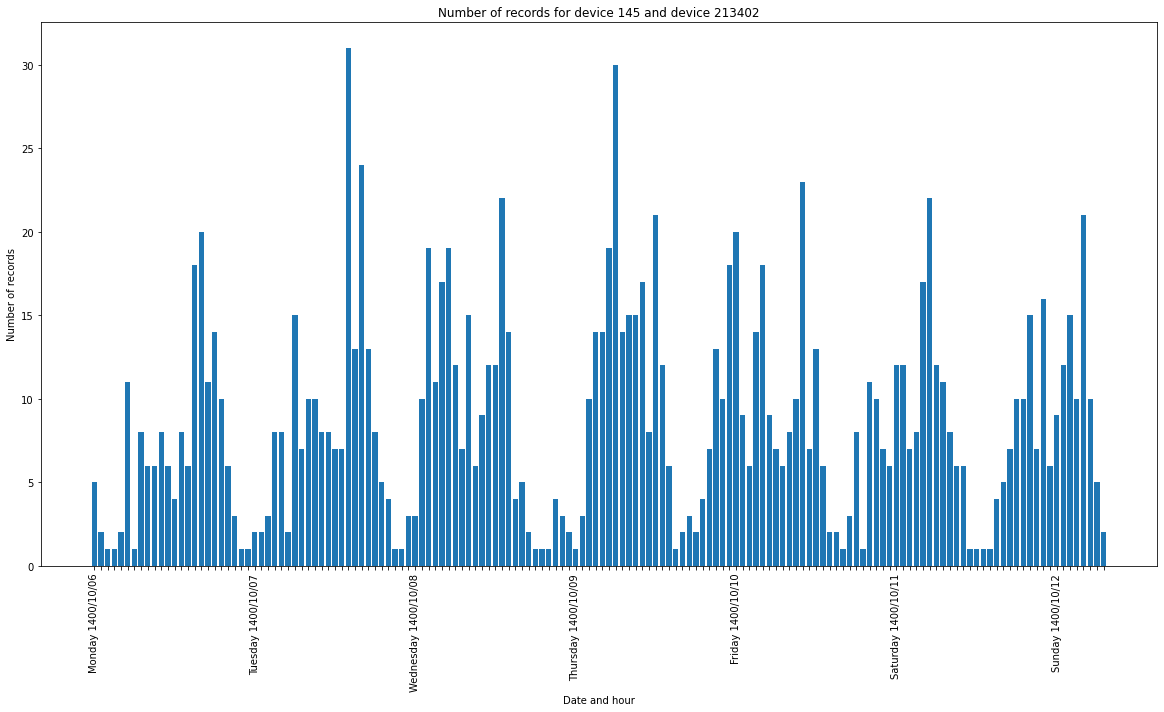

In [28]:
pair_records1 = sorted(pair_records1, key=lambda x: (x[0][0], x[0][1]))
pair_records1 = [(convert_to_persian_date(x[0][0]), x[0][1], x[1]) for x in pair_records1]
plot_histogram(device1, device2, pair_records1)

In [19]:
joined_rdd2 = rdd2.filter(lambda x: x[1][0] == device1).join(rdd2.filter(lambda x: x[1][0] == device2))

In [20]:
joined_rdd2.take(1)

[]

In [ ]:
joined_rdd2 = joined_rdd2.filter(lambda x: abs(x[1][0][1] - x[1][1][1]) <= 15)
joined_rdd2 = joined_rdd2.map(lambda x: ((x[0][1], x[1][0][1] // 60), 1)).reduceByKey(lambda x, y: x + y)
pair_records2 = joined_rdd2.collect()
pair_records2 = sorted(pair_records2, key=lambda x: (x[0][0], x[0][1]))
pair_records2 = [(convert_to_persian_date(x[0][0]), x[0][1], x[1]) for x in pair_records2]
plot_histogram(device1, device2, pair_records2)

In [ ]:
joined_rdd3 = rdd3.filter(lambda x: x[1][0] == device1).join(rdd3.filter(lambda x: x[1][0] == device2))
joined_rdd3.take(1)

In [ ]:
joined_rdd3 = joined_rdd3.filter(lambda x: abs(x[1][0][1] - x[1][1][1]) <= 15)
joined_rdd3 = joined_rdd3.map(lambda x: ((x[0][1], x[1][0][1] // 60), 1)).reduceByKey(lambda x, y: x + y)
pair_records3 = joined_rdd3.collect()
pair_records3 = sorted(pair_records3, key=lambda x: (x[0][0], x[0][1]))
pair_records3 = [(convert_to_persian_date(x[0][0]), x[0][1], x[1]) for x in pair_records3]
plot_histogram(device1, device2, pair_records3)

In [ ]:
joined_rdd4 = rdd4.filter(lambda x: x[1][0] == device1).join(rdd4.filter(lambda x: x[1][0] == device2))
joined_rdd4.take(1)

In [ ]:
joined_rdd4 = joined_rdd4.filter(lambda x: abs(x[1][0][1] - x[1][1][1]) <= 15)
joined_rdd4 = joined_rdd4.map(lambda x: ((x[0][1], x[1][0][1] // 60), 1)).reduceByKey(lambda x, y: x + y)
pair_records4 = joined_rdd4.collect()
pair_records4 = sorted(pair_records4, key=lambda x: (x[0][0], x[0][1]))
pair_records4 = [(convert_to_persian_date(x[0][0]), x[0][1], x[1]) for x in pair_records4]
plot_histogram(device1, device2, pair_records4)